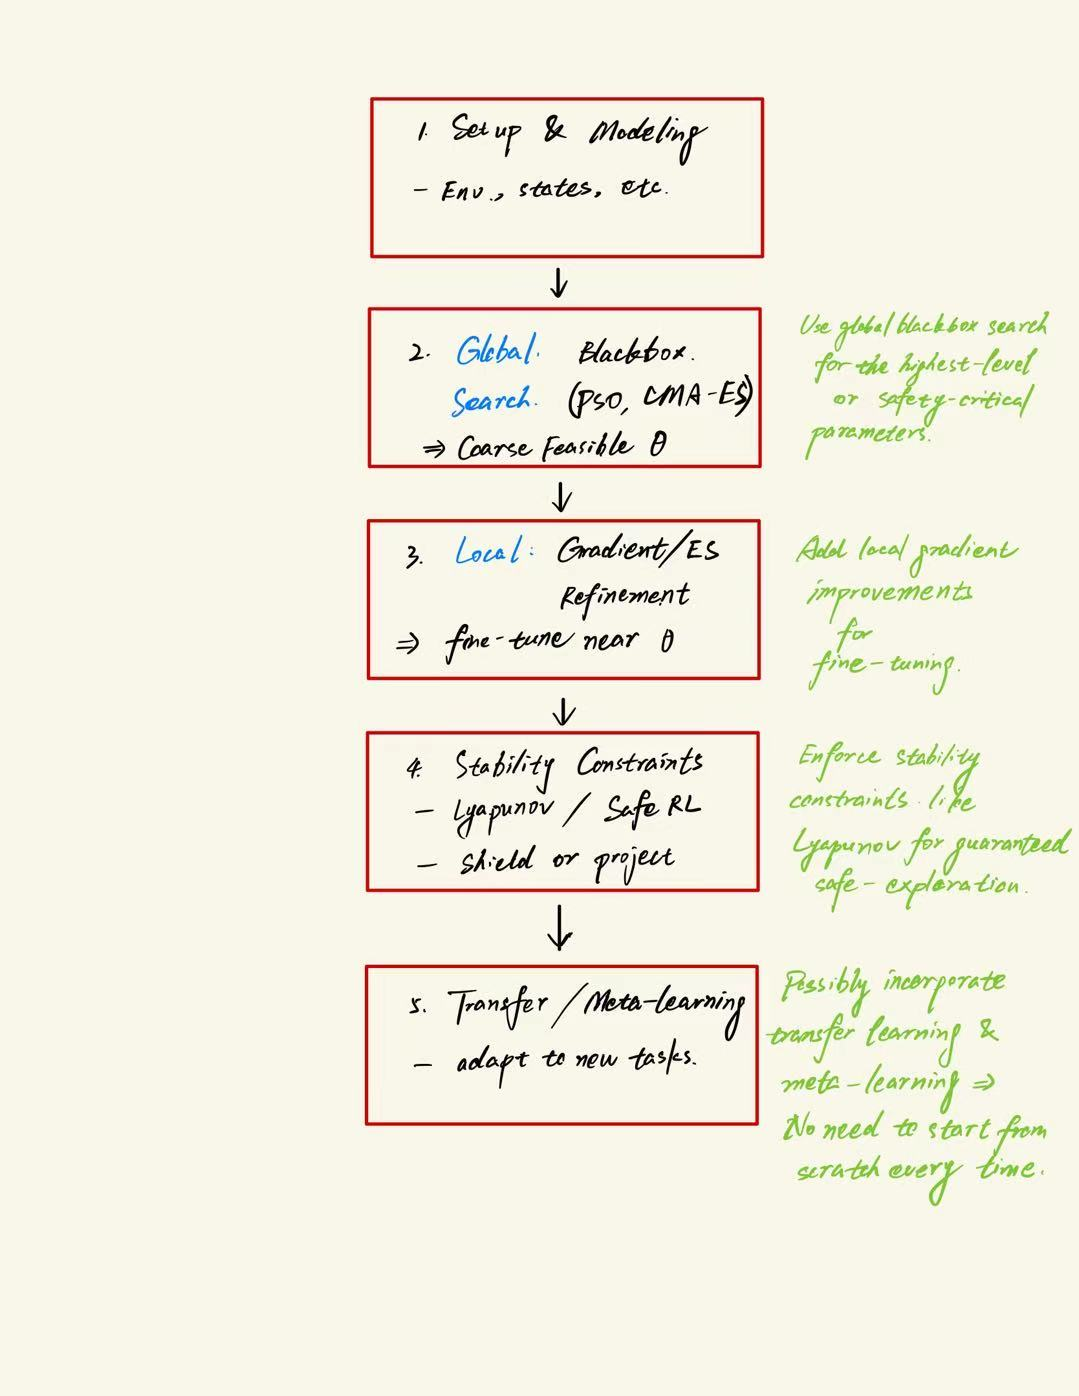

<span style="color:red">**I. Problem Setup & Modeling**</span>

1. Define the environment: (Two simulation experiments)
   * Simple System - single CSTR/ SISO
   * Complex System - large MIMO
   * Create a GYM environment:
     * observation $x_t$: states, setpoints, measurements
     * action $u_t$ or $K$: PID gains or direct control
     * reward $r_t$: tracking error + actuation penalty + constraints (or penalty terms for safety)
    
2. Controller-in-the-loop:
   * RL policy: outputs PID gains / direct manipulated variables (fit to existing PID)
   * If consider multiple loop problems, the policy can output ${(K_p, \tau_i, \tau_d)}_1, ..., {(K_p, \tau_i, \tau_d)}_m$ for m loops, or a vector of direct control actions.
   * In the environment:
     * Apply PID routine (gains), or
     * Directly set the actuation (direct control)
    
3. Constraints & Safety:
   * Identify physical constraints on states and manipulated variables (Temperature, flow, volume, etc.)
   * How to handle?
     * Hard clamping (clip in the environment)
     * Constraint penalty in the reward
     * Barrier Functions in a future step
    

<span style="color:red">**II. Global Blackbox Search for Feasible or Coarse Solutions**</span>

1. Motivation
   * We want an initial set of parameters $\theta$ (RL policy weights) that yields stable, feasible control and a decent cost/reward. => importance of initial guess
   * We do global blackbox search => avoid local minima or bad local optima in early stage
  
2. Algorithm selection:
   * criteria: sample efficiency, fast, global method
   * ParticleSwarmOptimizer (PSO), Covariance matrix adaptation evolution strategy (CEA-ES), or Bayesian Optmization, and many others
   * After a certain number of iterations or when improvement stalls, pick the best solution
  
3. Outputs:
   * A "good" / "coarse" / "mid-quality": $\theta_{global}$
   * Possibly: a region of parameter space that worked well

  
<span style="color:red">**III. Local Gradient Improvement**</span>

1. Initialize from $\theta_{global}$

2. Local Gradient Method:
   * motivation: faster & guaranteed
   * Option 1: Policy Gradient (PPO, TRPO, etc.) - updates after each episode or batch
   * Option 2: A derivative-free ES that uses finite-difference gradient estimates but starts near $\theta_{gloabal}$
   * Option 3: Hybrid approach - quasi-Newton for black functions or local MAML updates

3. Refining Process:
   * Because we are starting from a decent $\theta$, the local gradient method can quickly converge or refine near the region
   * Likely get better sample efficiency than purely global search, especially when the environment is costly to simulate

4. Reward function adjustments:
   * Possibly: add more refined penalties for overshoot, actuator usage, etc.
  

<span style="color:red"> **IV. Enforce Stability Constraints (Lyapunov / Safe Exploration)** </span>

1. Lyapunov or Barrier Function
   * If policy outputs PID gains within safe region, we can limit the search to that region (but this requires expert knowledge)
   * For direct control, incorporate control barrier functions to ensure states remain in a safe set
  
2. Implementation steps:
   1). After each update to $\theta$, project ot a set that ensures stability
   2). Add a exponential term to reward function if the closed-loop system violates a known stability condition
   3). Shielding: If RL policy tries to produce an "unsafe" action, we need to find a way to override it with a safe backup controller

3. Outcome (ideally)
   * The policy is refined only within stable or near-stable parameters, ensuring process never goes out of bounds
   * This part can be integrated into the local gradient step -- constraint policy gradient / safe ES
  
<span style="color:red"> **V. Transfer Learning / Meta-Learning** </span>

1. When
   * Have multiple related/similar tasks (setpoint tracking with different setpoints)
   * Want to adapt quickly without re-running the entire global + local search from scratch => important for chemical industries (especially those who use Factory settings for PIDs)
  
2. Techniques
   * Pre-training: Train the policy across a distribution of tasks or parameter variations. The final policy can handle these variations or adapt quickly.
   * Fine-tuning: For a new but similar system, start from old policy $\theta_{old}$ and do a shorter local update
   * Meta-RL: The policy is trained to adapt in juts a few steps if the environment changes
  
3. In chemical engineering settings:
   * Different operating regimes (low load vs. high load)
   * Continuous changing setpoints (for multi-grade manufacturing / multi-period operation)
   * Distillation column with high variance of feed composition

# Test 1: Simple SISO

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces

# For Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# For PPO local refinement
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.distributions import DiagGaussianDistribution

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='stable_baselines3')

from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3 import PPO

In [2]:
###########################################################################
# 1) SISO ENVIRONMENT WITH P and I
###########################################################################

class SISOEnv(gym.Env):
    """
     Discrete-time SISO environment with integral state:
      x_{k+1} = alpha*x_k + beta*u_k

    Observation = [x, e_int], where:
      - x is the current process variable,
      - e_int accumulates the tracking error e = (x_set - x).

    Action in [-1,1], mapped to [-5,5].

    Reward = -( 10*(error^2) + 0.01*(u^2) ).
      i.e. heavier emphasis on accurate setpoint tracking,
           smaller penalty on control usage.
    """
    def __init__(self, alpha=0.1, beta=0.9, horizon=100, x_set=1.0):
        super().__init__()

        self.alpha = alpha
        self.beta = beta
        self.horizon = horizon
        self.x_set = x_set

        # observation space: x in [-5, 5], e_int in [-50, 50]
        self.observation_space = spaces.Box(
            low = np.array([-5, -50], dtype=np.float32),
            high = np.array([5, 50], dtype=np.float32)
        )

        # actions: [-1, 1] ampped to [-5, 5]
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.x = 0.0
        self.e_int = 0.0   # integrator state
        self.done = False
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array([self.x, self.e_int], dtype=np.float32)

    def step(self, action):
        # Flatten action in case it arrives as a float
        action = np.array(action, dtype=float).flatten()
        # Map [-1,1] => [-5,5]
        u = 5.0 * action[0]

        # Current tracking error
        e = self.x_set - self.x
        self.e_int += e  # integrate

        # System update
        x_next = self.alpha*self.x + self.beta*u
        self.x = x_next

        self.t += 1
        if self.t >= self.horizon:
            self.done = True

        # Cost: heavier penalty on error^2, smaller on u^2
        cost = 10*(e**2) + 0.01*(u**2)
        reward = -cost

        return self._get_obs(), reward, self.done, False, {}

In [3]:
###########################################################################
# 2) QUICK ENV CHECK
###########################################################################

env_test = SISOEnv()
check_env(env_test, warn=True)

In [4]:
###########################################################################
# 3) LOW-D POLICY FOR BAYESIAN OPT 
#    Policy: a = tanh(W1*x + W2*e_int + B)
###########################################################################

def rollout_with_params(params, alpha=0.1, beta=0.9, horizon=100, x_set=1.0):
    """
    Evaluate policy: a = tanh(W1*x + W2*e_int + B) using full 2D observation.
    'params' => [W1, W2, B].
    Returns total reward.
    """
    W1, W2, B = params  # Unpack all three parameters
    env = SISOEnv(alpha=alpha, beta=beta, horizon=horizon, x_set=x_set)

    obs, _ = env.reset()
    total_r = 0
    done = False
    while not done:
        x, e_int = obs  # Use both observation components
        a = np.tanh(W1 * x + W2 * e_int + B)  # Policy with integral term
        obs, r, done, _, _ = env.step([a])
        total_r += r
    return total_r



In [5]:
###########################################################################
# 4) BAYESIAN OPT FOR GLOBAL SEARCH
###########################################################################

space = [
    Real(-10.0, 10.0, name='W1'),  # Weight for x
    Real(-10.0, 10.0, name='W2'),  # Weight for e_int
    Real(-10.0, 10.0, name='B'),   # Bias
]

@use_named_args(space)
def objective(**kwargs):
    W1 = kwargs['W1']
    W2 = kwargs['W2']
    B = kwargs['B']
    rew = rollout_with_params([W1, W2, B])  # Pass all three parameters
    return -rew  # Minimize negative reward

print("Running Bayesian Optimization for global param search...")
res_gp = gp_minimize(
    objective,
    dimensions=space,
    n_calls=30,
    n_initial_points=10,
    acq_func='EI',
    random_state=123
)
best_params = res_gp.x  
best_score = -res_gp.fun
print(f"Found best params (W1, W2, B)={best_params}, reward={best_score:.3f}")

Running Bayesian Optimization for global param search...
Found best params (W1, W2, B)=[-1.78151254581962, 1.5938859404522034, -7.200984747392309], reward=-12091.957


In [6]:
###########################################################################
# 5) PPO FOR LOCAL GRADIENT IMPROVEMENT
#   define a small policy net that uses the full 2D observation:
###########################################################################

class SmallMLP(nn.Module):
    def __init__(self, obs_dim=2, hidden=16, init_W1=None, init_W2=None, init_B=None):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.out = nn.Linear(hidden, 1)

        # initialize the first layer weights and biases from previous
        if init_W1 is not None and init_W2 is not None and init_B is not None:
            with torch.no_grad():
                # set the first layer weights
                self.fc1.weight[0, 0] = init_W1
                self.fc1.weight[0, 1] = init_W2
                # set the first layer bias
                self.fc1.bias[0] = init_B

    def forward(self, x):
        # x shape => (batch_size, obs_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # final => tanh => action in [-1,1]
        return torch.tanh(self.out(x))

class CustomPolicy(BasePolicy):
    def __init__(self, observation_space, action_space, lr_schedule,
                 init_W1, init_W2, init_B, **kwargs):
        super().__init__(observation_space, action_space, features_extractor=None)
        self.lr_schedule = lr_schedule
        self.obs_dim = observation_space.shape[0]
        self.policy_net = SmallMLP(obs_dim=self.obs_dim,
                                   hidden=16,
                                   init_W1=init_W1,
                                   init_W2=init_W2,
                                   init_B=init_B)
        self.value_net = nn.Linear(self.obs_dim, 1)
        self.action_dist = DiagGaussianDistribution(1)

        # optional usage of the BayesOpt result, e.g. initialize
        # the first layer close to "W, B" if you want
        # (we won't do that in detail since now we have 16 hidden units).
        self._setup_model()

    def _setup_model(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_schedule(1))

    def forward(self, obs, deterministic=False):
        mean = self.policy_net(obs)  # shape (batch_size,1)
        mean = mean.squeeze(-1)      # shape (batch_size,)
        log_std = torch.zeros_like(mean)

        val = self.value_net(obs)
        val = val.squeeze(-1)
        return mean, val, log_std

    def _predict(self, observation, deterministic=False):
        mean, _, log_std = self.forward(observation)
        if deterministic:
            return mean.unsqueeze(-1)
        else:
            action = self.action_dist.sample(mean, log_std)
            return action.unsqueeze(-1)

    def evaluate_actions(self, obs, actions):
        mean, val, log_std = self.forward(obs)
        var = torch.exp(2 * log_std)

        # shape fix
        actions = actions.view(-1)

        log_prob = -((actions - mean)**2)/(2*var) - log_std - 0.5*np.log(2*np.pi)
        entropy = log_std + 0.5*np.log(2*np.pi*np.e)

        return val, log_prob, entropy

    def predict_values(self, obs):
        with torch.no_grad():
            _, val, _ = self.forward(obs)
            return val


# Create a single-env with x_set=1.0 for local PPO refinement
vec_env = DummyVecEnv([lambda: SISOEnv(x_set=1.0, horizon=100)])
init_W1, init_W2, init_B = best_params

policy_kwargs = dict(init_W1=init_W1, init_W2=init_W2, init_B=init_B)
model = PPO(
    policy=CustomPolicy,
    env=vec_env,
    policy_kwargs=policy_kwargs,
    n_steps=256,
    batch_size=64,
    verbose=0
)

print("Training PPO locally from BayesOpt initialization...")
model.learn(total_timesteps=3000)

Training PPO locally from BayesOpt initialization...


In [7]:
###########################################################################
# 6) Evaluate the final policy
###########################################################################

def evaluate_sb3_model(model, x_set=1.0):
    test_env = SISOEnv(x_set=x_set, horizon=100)
    obs, _ = test_env.reset()
    total_r = 0
    done = False
    while not done:
        act, _ = model.predict(obs, deterministic=True)
        obs, r, done, _, _ = test_env.step(act)
        total_r += r
    return total_r

final_reward = evaluate_sb3_model(model, x_set=1.0)
print(f"PPO final policy reward ~ {final_reward:.3f}")

PPO final policy reward ~ -25.352


In [8]:
###########################################################################
# 7) META-LEARNING
###########################################################################

meta_envs = [
    lambda: SISOEnv(x_set=0.5),
    lambda: SISOEnv(x_set=1.0),
    lambda: SISOEnv(x_set=2.0),
]
meta_venv = DummyVecEnv(meta_envs)

meta_model = PPO(
    policy=CustomPolicy,
    env=meta_venv,
    policy_kwargs=policy_kwargs,
    n_steps=256,
    batch_size=64,
    verbose=0
)

print("Meta-training on multiple setpoints [0.5, 1.0, 2.0] ...")
meta_model.learn(total_timesteps=3000)
meta_model.save("meta_model.zip")

# Now adapt quickly to x_set = 1.5
adapt_env = DummyVecEnv([lambda: SISOEnv(x_set=1.5, horizon=100)])
new_model = PPO.load("meta_model.zip", env=adapt_env)
print("Adapting policy quickly for new setpoint x_set=1.5 ...")
new_model.learn(total_timesteps=1000)

test_r = evaluate_sb3_model(new_model, x_set=1.5)
print(f"Final reward on new setpoint x_set=1.5 => {test_r:.3f}")

print("\nDone! This code demonstrates:")
print("1) An integrator in the environment's observation ([x, e_int]).")
print("2) A cost function that heavily penalizes tracking error (10*e^2).")
print("3) Bayesian Optimization + PPO for local refinement.")
print("4) Meta-training on multiple setpoints, then quick adaptation to x_set=1.5.")

Meta-training on multiple setpoints [0.5, 1.0, 2.0] ...
Adapting policy quickly for new setpoint x_set=1.5 ...
Final reward on new setpoint x_set=1.5 => -233.344

Done! This code demonstrates:
1) An integrator in the environment's observation ([x, e_int]).
2) A cost function that heavily penalizes tracking error (10*e^2).
3) Bayesian Optimization + PPO for local refinement.
4) Meta-training on multiple setpoints, then quick adaptation to x_set=1.5.


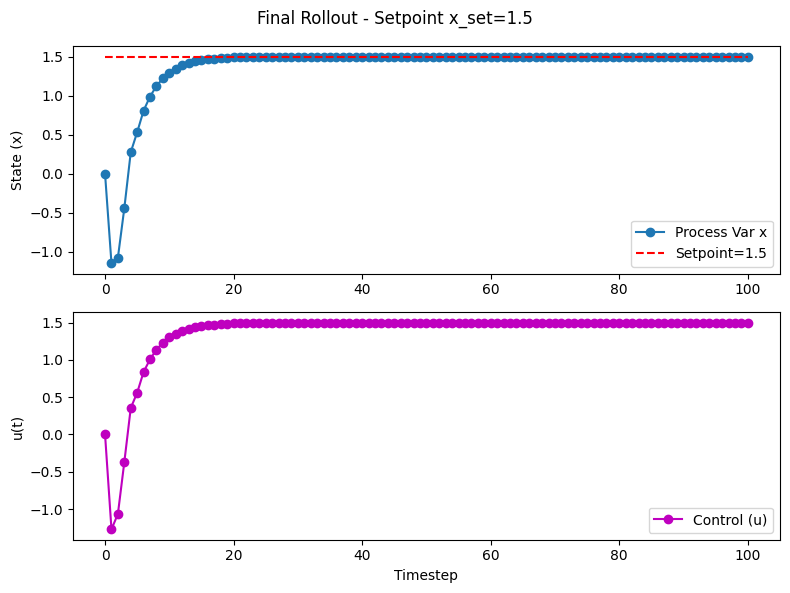

In [9]:
###########################################################################
# 8) PLOT THE FINAL ROLLOUT
###########################################################################
def plot_final_rollout(model, x_set=1.0, horizon=200):
    """
    Run a single rollout with the given model and setpoint,
    collect (x_t, u_t), and plot them.
    """
    env = SISOEnv(x_set=x_set, horizon=horizon)
    obs, _ = env.reset()

    xs = [env.x]
    us = [0.0]
    done=False

    while not done:
        act, _ = model.predict(obs, deterministic=True)
        a = np.array(act, dtype=float).flatten()[0]
        u = 5.0*a  # scale from [-1,1] => [-5,5]

        obs, r, done, _, _ = env.step(act)
        xs.append(env.x)
        us.append(u)

    ts = np.arange(len(xs))
    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(ts, xs, '-o', label='Process Var x')
    plt.hlines(x_set, 0, len(xs)-1, colors='r', linestyles='--', label=f'Setpoint={x_set}')
    plt.ylabel('State (x)')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(ts, us, '-o', color='m', label='Control (u)')
    plt.ylabel('u(t)')
    plt.xlabel('Timestep')
    plt.legend()

    plt.suptitle(f"Final Rollout - Setpoint x_set={x_set}")
    plt.tight_layout()
    plt.show()

# Finally, show how well the adapted policy does on x_set=1.5
plot_final_rollout(new_model, x_set=1.5, horizon=100)


# Test 2: Cascade PID

https://www.mathworks.com/help/control/ug/designing-cascade-control-system-with-pi-controllers.html

2025-02-07 11:15:46,858 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=0.563
2025-02-07 11:15:48,340 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.562941715590056, best pos: [5.92807601 8.20638382 9.7830832  0.83253447]


Best cost from PSO: 0.562941715590056
Best Gains: (Kp_in,Ki_in,Kp_out,Ki_out)= [5.92807601 8.20638382 9.7830832  0.83253447]
Using cuda device
----------------------------
| time/              |     |
|    fps             | 143 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 64  |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 145          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 5.401671e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 4.04e+11     |
|    n_updates            | 10           |
|    poli

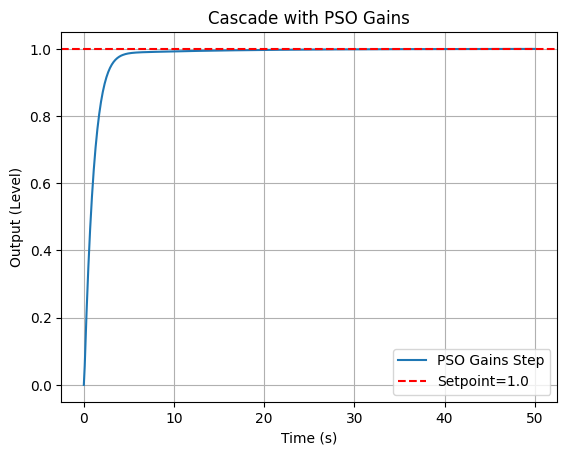

Demonstration of Cascade PID Tuning with PSO, PPO, Transfer Learning.


In [24]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import control as ctrl
import matplotlib.pyplot as plt

# We'll use PySwarms for PSO
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# For local gradient improvement with PPO
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env

###########################################################################
# CASCADE PID ENVIRONMENT
###########################################################################
class CascadeEnv(gym.Env):
    """
    A 1-step environment for tuning cascade PI gains.
    Actions = [Kp_in, Ki_in, Kp_out, Ki_out].
    Simulate the step response of the closed-loop system,
    measure cost, and return reward = -cost.
    'done' = True after one step => single-episode environment.
    
    By default, the setpoint is 1.0. We can change it in 'reset()' if we want to do "transfer".
    """
    def __init__(self, setpoint=1.0, overshoot_limit=30.0):
        super().__init__()
        # store the setpoint for reference, used in step response
        self.setpoint = setpoint
        # define an action space: [Kp_in, Ki_in, Kp_out, Ki_out] each in [0, 10]
        self.action_space = spaces.Box(low=np.array([0,0,0,0], dtype=np.float32),
                                       high=np.array([10,10,10,10], dtype=np.float32))
        # single-step => observation might be trivial; define empty or 1D for SB3
        # do an observation_space with shape (1,) for a dummy
        self.observation_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # overshoot "safety" limit (e.g. 30% overshoot)
        self.overshoot_limit = overshoot_limit
        self.done_already = False

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.done_already = False
        # no real state, so return a dummy
        return np.array([0.0], dtype=np.float32), {}

    def step(self, action):
        """
        action => [Kp_in, Ki_in, Kp_out, Ki_out]
        We'll build the cascade system, do step response, measure cost.
        """
        if self.done_already:
            # If we step again after done, just return something
            return np.array([0.0], dtype=np.float32), 0.0, True, False, {}
        
        # Clip or convert to avoid negative gains if you want
        act = np.clip(action, 0, 10)
        Kp_in, Ki_in, Kp_out, Ki_out = act

        # build the cascade system
        # Inner loop plant:
        inner_plant = ctrl.TransferFunction([4], [1,4]) 
        # Outer loop plant:
        outer_plant = ctrl.TransferFunction([1], [10,1])

        # build inner loop PI
        inner_pi = ctrl.TransferFunction([Kp_in, Ki_in], [1, 0])
        inner_closed = ctrl.feedback(inner_pi*inner_plant, 1)

        # outer loop with that inner loop
        outer_pi = ctrl.TransferFunction([Kp_out, Ki_out], [1, 0])
        # "cascade" => multiply outer_plant * the closed inner loop
        cascade_sys = ctrl.feedback(outer_pi * inner_closed * outer_plant, 1)

        # simulate step to 'setpoint=1.0' => do scale if you want a different setpoint
        # for simplicity we consider a 1-step as the step from 0 to 1
        t, y = ctrl.step_response(cascade_sys, T=np.linspace(0, 50, 500))  # 50s with 500 points

        # measure performance => overshoot, settling time, ISE...
        # we want to penalize large overshoot or slow settling, etc.
        # define a cost
        overshoot = (np.max(y) - 1.0)*100.0  # percent overshoot
        ise = np.trapezoid((y - 1.0)**2, t)      # integral of squared error
        # if overshoot is negative, it means y<1 at peak => overshoot= negative => we can clip
        overshoot = max(0.0, overshoot)

        # safety constraint => if overshoot > limit => massive penalty
        safety_penalty = 0.0
        if overshoot > self.overshoot_limit:
            safety_penalty = 10000.0*(overshoot - self.overshoot_limit)

        cost = ise + 0.1*overshoot + safety_penalty
        reward = -cost

        # single step => done
        self.done_already = True
        obs = np.array([0.0], dtype=np.float32)  # dummy
        return obs, reward, True, False, {}

###########################################################################
# QUICK CHECK
###########################################################################
env = CascadeEnv()
check_env(env, warn=True)

###########################################################################
# 1) PSO for global search with safety constraint
###########################################################################
# We'll define a function that PSO can call => returns cost for each param
def pso_objective(params):
    """
    params shape => (n_particles, 4)
    For each row => [Kp_in, Ki_in, Kp_out, Ki_out], we do a step,
    measure cost => we want to minimize cost => we return cost
    """
    n_particles = params.shape[0]
    costs = []
    for i in range(n_particles):
        # build system
        Kp_in, Ki_in, Kp_out, Ki_out = params[i,:]
        # clip in [0,10]
        Kp_in, Ki_in, Kp_out, Ki_out = np.clip([Kp_in, Ki_in, Kp_out, Ki_out], 0, 10)

        # run the environment
        # single step => we do 'env.reset()', 'env.step(action)'
        # just replicate the same logic here or we can build a local env
        inner_plant = ctrl.TransferFunction([4],[1,4])
        outer_plant = ctrl.TransferFunction([1],[10,1])

        inner_pi = ctrl.TransferFunction([Kp_in, Ki_in],[1,0])
        inner_closed = ctrl.feedback(inner_pi*inner_plant,1)

        outer_pi = ctrl.TransferFunction([Kp_out, Ki_out],[1,0])
        cascade_sys = ctrl.feedback(outer_pi*inner_closed*outer_plant,1)

        t = np.linspace(0,50,500)
        t, y = ctrl.step_response(cascade_sys, T=t)

        overshoot = (np.max(y)-1.0)*100.0
        overshoot = max(0, overshoot)
        ise = np.trapezoid((y-1.0)**2, t)
        cost = ise + 0.1*overshoot
        # safety => if overshoot>30 => big penalty
        if overshoot>30:
            cost += 10000*(overshoot-30)
        costs.append(cost)
    return np.array(costs)

# use PySwarms to do global search
options = {'c1':0.5, 'c2':0.3, 'w':0.9}
bounds_low = [0,0,0,0]
bounds_high= [10,10,10,10]
bounds = (bounds_low, bounds_high)

optimizer = ps.single.GlobalBestPSO(n_particles=40, dimensions=4,
                                    options=options, bounds=bounds)
best_cost, best_pos = optimizer.optimize(pso_objective, iters=10)
print("Best cost from PSO:", best_cost)
print("Best Gains: (Kp_in,Ki_in,Kp_out,Ki_out)=",best_pos)

###########################################################################
# 2) PPO for local improvement
###########################################################################
# define a single-step environment => we do repeated episodes => PPO tries to find best action
# start near the PSO solution => we can "seed" the policy or do an init
import numpy as np
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

local_env = CascadeEnv()
vec_env = DummyVecEnv([lambda: local_env])  # single-step env
check_env(local_env, warn=True)

from stable_baselines3 import PPO

# do a standard MlpPolicy
# We'll "rescale" them inside the environment by clipping. That might cause suboptimal training,
model = PPO("MlpPolicy", vec_env, verbose=1, n_steps=64, batch_size=64)
model.learn(total_timesteps=2000)

# Evaluate final policy
def eval_policy(policy, env, n_eval=20):
    costs = []
    for i in range(n_eval):
        obs, _ = env.reset()
        done=False
        total_r = 0
        while not done:
            act,_ = policy.predict(obs, deterministic=True)
            obs,r,done,_,_ = env.step(act)
            total_r += r
        costs.append(-total_r)  # cost = -reward
    return np.mean(costs)

final_cost = eval_policy(model, local_env)
print("Final cost after PPO local improvement:", final_cost)

###########################################################################
# 3) Transfer to new scenario => e.g. changing the inner loop setpoint
###########################################################################
# Let's define an environment that modifies the setpoint from 1.0 => 2.0 in the inner loop
# Actually, in cascade, "setpoint=1.0" is for the outer loop. We'll do the same environment
# but with 'setpoint=2.0', or we might define a new 'CascadeEnv2'
transfer_env = CascadeEnv(setpoint=2.0)
vec_transfer = DummyVecEnv([lambda: transfer_env])

# Evaluate old model on new setpoint
old_cost = eval_policy(model, transfer_env)
print("Old policy cost on new setpoint=2.0:", old_cost)

# Fine-tune
model.set_env(vec_transfer)
model.learn(total_timesteps=1000)
transfer_cost = eval_policy(model, transfer_env)
print("Cost after fine-tuning on setpoint=2.0:", transfer_cost)

###########################################################################
# 4) Plot a final step response with best Gains or with the PPO policy
###########################################################################
def step_response_with_gains(Kp_in,Ki_in,Kp_out,Ki_out, setpoint=1.0):
    inner_plant= ctrl.TransferFunction([4],[1,4])
    outer_plant= ctrl.TransferFunction([1],[10,1])
    inner_pi   = ctrl.TransferFunction([Kp_in,Ki_in],[1,0])
    inner_closed = ctrl.feedback(inner_pi*inner_plant,1)
    outer_pi   = ctrl.TransferFunction([Kp_out,Ki_out],[1,0])
    cascade_sys= ctrl.feedback(outer_pi*inner_closed*outer_plant,1)
    t = np.linspace(0,50,500)
    t,y = ctrl.step_response(cascade_sys,t)
    return t,y

bestKp_in, bestKi_in, bestKp_out, bestKi_out = best_pos
t_pso, y_pso = step_response_with_gains(bestKp_in,bestKi_in,bestKp_out,bestKi_out)
plt.figure()
plt.plot(t_pso,y_pso,label="PSO Gains Step")
plt.axhline(1, color='r', linestyle='--',label="Setpoint=1.0")
plt.xlabel("Time (s)")
plt.ylabel("Output (Level)")
plt.title("Cascade with PSO Gains")
plt.legend()
plt.grid()
plt.show()

print("Demonstration of Cascade PID Tuning with PSO, PPO, Transfer Learning.")


2025-02-07 11:19:29,964 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: ov

PSO best cost: 22.062621444101154
PSO best gains: [1.40846227 7.45171655 4.50172055 0.48422722]
Using cuda device
-----------------------------
| time/              |      |
|    fps             | 501  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 1024 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 547           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 1.9848812e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 9.54e+11      |
|    n_updates            | 10            |
|    policy_grad

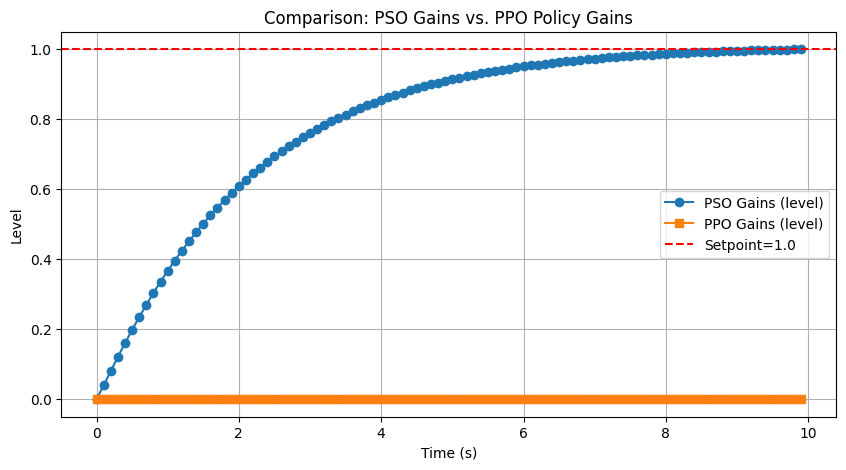


=== TRANSFER to new setpoint=2.0 ===


2025-02-07 11:19:49,326 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: overflow encountered in cast
  return np.array([
C:\Users\26088\AppData\Local\Temp\ipykernel_7516\4058642080.py:94: RuntimeWarning: ov

PSO(transfer) best cost: 88.38658992683115
PSO(transfer) best gains: [1.0857032  7.13654613 4.46219336 0.52615139]
-----------------------------
| time/              |      |
|    fps             | 486  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 1024 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 521           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 9.8661985e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.5e+12       |
|    n_updates            | 110           |
|    policy_gra

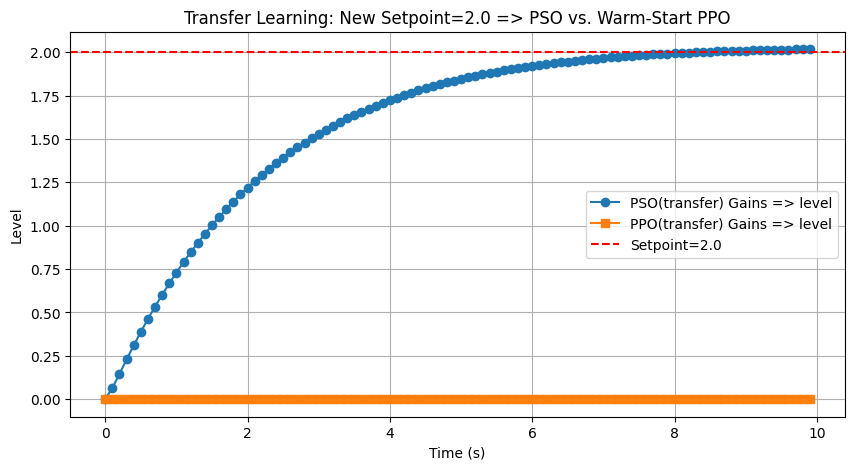


All done! We showed:
1) Multi-step environment for cascade PID.
2) PSO for global search (setpoint=1.0) => Gains => compare step response.
3) PPO local refinement => compare step response.
4) Transfer to new setpoint=2.0 => new PSO => new PPO warm start => final plots.


In [27]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

import control
import matplotlib.pyplot as plt

import pyswarms as ps
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env


###########################################################################
# 1) MULTI-STEP CASCADE ENVIRONMENT (DISCRETE)
###########################################################################
class CascadePIDMultiStepEnv(gym.Env):
    """
    A multi-step environment modeling a discrete-time version of
    a cascade control loop (inner loop for flow, outer loop for level).
    
    - We have 4 "tunable" gains that remain constant over an entire episode:
        Kp_in, Ki_in, Kp_out, Ki_out
      The environment uses those gains each time step to compute the control signals.
    
    - We simulate the system in discrete time:
        x_flow(k+1)  = ...
        x_level(k+1) = ...
      etc. using Euler or some simple approximation.

    - The "action" for the RL agent is the 4 gains (in [0,10], say).
      Once set at the start of the episode, we keep them fixed for the horizon.

    - At each step, we compute the flow control error, level control error, PID integrators,
      then update the states.

    - The episode runs for 'max_steps'. We accumulate reward each step:
        reward_t = -[ error_level^2 + 0.1 * error_flow^2 + 0.01*control^2 + safety_penalty ]
      (with a big penalty if overshoot > certain limit).

    - "setpoint" is the target level. We can do "flow_sp" as the inner loop reference
      that is commanded by the outer loop's controller output.

    - We'll do a naive discrete model:
        Flow plant:  x_flow(k+1) = x_flow(k) + dt*( -4*x_flow(k) + 4*u_in )  (like 4/(s+4))
        Level plant: x_level(k+1) = x_level(k) + dt*( -(1/10)*x_level(k) + (1/10)*flow ) 
                     => from 1/(10s+1)

      Where u_in is the control signal from the inner PID.
      The outer PID output becomes the "flow setpoint" for the inner loop.
    """
    def __init__(self, 
                 setpoint=1.0,
                 dt=0.1,
                 max_steps=100,
                 overshoot_limit=30.0):
        super().__init__()
        self.setpoint = setpoint
        self.dt = dt
        self.max_steps = max_steps
        self.overshoot_limit = overshoot_limit

        # We'll store the PID integrators for inner and outer loops
        # and the states: (flow, level)
        # Observations: (flow, level, e_flow_int, e_level_int, t)
        # We'll store them in a Box space with wide ranges
        high = np.array([50., 50., 1e2, 1e2, float(max_steps-1)], dtype=np.float32)
        low  = np.array([-50., -50., -1e2, -1e2, 0.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # The action is 4 gains: [Kp_in, Ki_in, Kp_out, Ki_out] in [0,10]
        self.action_space = spaces.Box(low=np.array([0.,0.,0.,0.],dtype=np.float32),
                                       high=np.array([10.,10.,10.,10.],dtype=np.float32))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        # States
        self.flow = 0.0
        self.level= 0.0
        self.e_flow_int = 0.0
        self.e_level_int= 0.0

        # We'll store the action (gains) once set => remain the same
        self.gains = None

        # For overshoot detection
        self.overshoot = 0.0  # track the max((level - setpoint)*100)

        obs = self._get_obs()
        return obs, {}

    def _get_obs(self):
        return np.array([
            self.flow,
            self.level,
            self.e_flow_int,
            self.e_level_int,
            float(self.t)
        ], dtype=np.float32)

    def step(self, action):
        """
        If it's the first step => interpret action as the 4 gains => store them.
        Then do one step of the system update using those gains.
        """
        # clamp action in [0,10]
        action = np.clip(action, 0, 10)
        # If we haven't stored them yet, store them
        if self.gains is None:
            self.gains = action.copy()

        # Gains
        Kp_in, Ki_in, Kp_out, Ki_out = self.gains
        dt = self.dt

        # Outer loop: e_level = setpoint - level
        e_level = self.setpoint - self.level
        self.e_level_int += e_level*dt
        # outer PID output => flow_sp
        flow_sp = Kp_out*e_level + Ki_out*self.e_level_int

        # Inner loop: e_flow = flow_sp - flow
        e_flow = flow_sp - self.flow
        self.e_flow_int += e_flow*dt
        # inner PID => u_in
        u_in = Kp_in*e_flow + Ki_in*self.e_flow_int
        # saturate or keep it free? We'll just let it go free for demonstration

        # Now update flow, level with naive Euler approx
        # flow plant => derivative ~ -4*flow + 4*u_in => flow(t+1)=flow(t)+dt*(...)
        self.flow += dt * ( -4*self.flow + 4*u_in )

        # level plant => derivative ~ -(1/10)*level + (1/10)*flow
        self.level+= dt * ( -(1./10.)*self.level + (1./10.)*self.flow )

        # update overshoot if any
        overshoot_pct = (self.level - self.setpoint)*100.0
        if overshoot_pct>self.overshoot:
            self.overshoot= overshoot_pct

        # compute cost
        # e_level^2 + 0.1* e_flow^2 + 0.01*(u_in^2 + flow_sp^2) => plus penalty if overshoot> limit
        cost = (e_level**2 + 0.1*e_flow**2 
                + 0.01*(u_in**2 + flow_sp**2))
        penalty= 0.0
        if self.overshoot> self.overshoot_limit:
            penalty= 10000*(self.overshoot-self.overshoot_limit)
        cost+= penalty
        reward = float(-cost)

        self.t += 1
        done=False
        if self.t>= self.max_steps:
            done=True

        obs = self._get_obs()
        return obs, reward, done, False, {}

###########################################################################
# CHECK ENV
###########################################################################
env = CascadePIDMultiStepEnv()
check_env(env, warn=True)

###########################################################################
# 2) PSO for global search on the multi-step environment
###########################################################################
# We'll define a helper function that, given a 4-vector of gains, returns
# the NEGATIVE final total reward (i.e. a cost) after simulating an episode.
def pso_rollout_cost(params):
    """
    params shape => (n_particles, 4)
    We'll do 1 episode for each row, get the total (negative) reward => cost
    """
    n_particles = params.shape[0]
    costs = np.zeros(n_particles)
    for i in range(n_particles):
        # clamp
        Kp_in, Ki_in, Kp_out, Ki_out = np.clip(params[i,:], 0, 10)
        # simulate an episode
        local_env = CascadePIDMultiStepEnv(setpoint=1.0, max_steps=100)
        obs, _ = local_env.reset()
        done=False
        total_r=0.0
        while not done:
            # at the first step, we provide (Kp_in, Ki_in, Kp_out, Ki_out)
            # afterwards, the env ignores action changes (the same gains are used)
            obs, r, done, _, _ = local_env.step([Kp_in, Ki_in, Kp_out, Ki_out])
            total_r+= r
        cost= -total_r  # cost= negative reward
        costs[i]= cost
    return costs

import pyswarms as ps
bounds_lower= [0,0,0,0]
bounds_upper= [10,10,10,10]
bounds= (bounds_lower, bounds_upper)
options= {'c1':0.5, 'c2':0.3, 'w':0.9}

optimizer= ps.single.GlobalBestPSO(n_particles=20, dimensions=4,
                                   options=options,
                                   bounds=bounds)
best_cost, best_pos= optimizer.optimize(pso_rollout_cost, iters=30)
print("PSO best cost:", best_cost)
print("PSO best gains:", best_pos)

###########################################################################
# 3) PPO for local gradient refinement
###########################################################################
# We'll create a single instance of the environment, or better, a VecEnv
# We'll store the PSO solution => we can do a small "wrapper" to initialize
# the policy near that solution if we want. For simplicity, let's just let PPO
# learn from scratch.
vec_env = DummyVecEnv([lambda: CascadePIDMultiStepEnv(setpoint=1.0, max_steps=100)])
model = PPO("MlpPolicy", vec_env, verbose=1, n_steps=1024, batch_size=256)
model.learn(total_timesteps=10000)

# Evaluate final policy => we run one episode
def evaluate_policy(policy, setpoint=1.0, episodes=5):
    rewards=[]
    for ep in range(episodes):
        env_test= CascadePIDMultiStepEnv(setpoint=setpoint, max_steps=100)
        obs, _= env_test.reset()
        done=False
        ep_r=0
        while not done:
            # action in env => 4 dims => we let policy pick them
            # Policy might produce anything in [-1,1]^4 => we clamp in env anyway
            act,_= policy.predict(obs, deterministic=True)
            obs, r, done, _, _= env_test.step(act)
            ep_r+= r
        rewards.append(ep_r)
    return np.mean(rewards)

final_r= evaluate_policy(model, setpoint=1.0)
print("After PPO local refinement, average reward=", final_r)

###########################################################################
# 4) PLOT Step Response for Gains from PSO vs Gains from PPO
###########################################################################
# We'll define a function that "locks in" gains => run the multi-step discrete sim => store time, level
def run_episode_with_gains(Kp_in,Ki_in,Kp_out,Ki_out, setpoint=1.0):
    env_test= CascadePIDMultiStepEnv(setpoint=setpoint, max_steps=100)
    obs, _= env_test.reset()
    flow_hist=[]
    level_hist=[]
    t_hist=[]
    for step in range(env_test.max_steps):
        flow_hist.append(env_test.flow)
        level_hist.append(env_test.level)
        t_hist.append(step*env_test.dt)
        # we pass same gains each step
        obs, r, done, _, _= env_test.step([Kp_in,Ki_in,Kp_out,Ki_out])
        if done: 
            break
    return np.array(t_hist), np.array(flow_hist), np.array(level_hist)

def run_episode_with_policy(policy, setpoint=1.0):
    env_test= CascadePIDMultiStepEnv(setpoint=setpoint, max_steps=100)
    obs, _= env_test.reset()
    flow_hist=[]
    level_hist=[]
    t_hist=[]
    for step in range(env_test.max_steps):
        flow_hist.append(env_test.flow)
        level_hist.append(env_test.level)
        t_hist.append(step*env_test.dt)

        act,_= policy.predict(obs, deterministic=True)
        obs, r, done, _, _= env_test.step(act)
        if done:
            break
    return np.array(t_hist), np.array(flow_hist), np.array(level_hist)

import matplotlib.pyplot as plt

bestKp_in, bestKi_in, bestKp_out, bestKi_out= best_pos
t_pso, f_pso, l_pso = run_episode_with_gains(bestKp_in, bestKi_in, bestKp_out, bestKi_out, setpoint=1.0)
t_ppo, f_ppo, l_ppo = run_episode_with_policy(model, setpoint=1.0)

plt.figure(figsize=(10,5))
plt.plot(t_pso, l_pso, '-o', label="PSO Gains (level)")
plt.plot(t_ppo, l_ppo, '-s', label="PPO Gains (level)")
plt.axhline(1.0, color='r', ls='--', label='Setpoint=1.0')
plt.xlabel("Time (s)")
plt.ylabel("Level")
plt.title("Comparison: PSO Gains vs. PPO Policy Gains")
plt.legend()
plt.grid()
plt.show()

###########################################################################
# 5) TRANSFER LEARNING: new setpoint=2.0 => run PSO => run PPO warm start
###########################################################################
print("\n=== TRANSFER to new setpoint=2.0 ===")

# (a) Quick new PSO search => we pass setpoint=2.0 to pso_rollout_cost, or define a new function
def pso_rollout_cost_transfer(params):
    n_particles= params.shape[0]
    costs= np.zeros(n_particles)
    for i in range(n_particles):
        Kp_in, Ki_in, Kp_out, Ki_out= np.clip(params[i,:], 0,10)
        local_env= CascadePIDMultiStepEnv(setpoint=2.0, max_steps=100)
        obs,_= local_env.reset()
        total_r=0
        done=False
        while not done:
            obs, r, done, _, _= local_env.step([Kp_in, Ki_in, Kp_out, Ki_out])
            total_r+=r
        cost= -total_r
        costs[i]= cost
    return costs

optimizer2= ps.single.GlobalBestPSO(n_particles=20, dimensions=4,
                                    options=options, bounds=bounds)
best_cost2, best_pos2= optimizer2.optimize(pso_rollout_cost_transfer, iters=30)
print("PSO(transfer) best cost:", best_cost2)
print("PSO(transfer) best gains:", best_pos2)

# (b) Fine-tune PPO from old model => new setpoint=2.0
# We'll do a new env
transfer_vec_env= DummyVecEnv([lambda: CascadePIDMultiStepEnv(setpoint=2.0, max_steps=100)])
# We'll reuse the old model. That is the "warm start" approach.
model.set_env(transfer_vec_env)
model.learn(total_timesteps=5000)

final_r2= evaluate_policy(model, setpoint=2.0)
print("After warm-start PPO refinement on setpoint=2.0 => average reward=", final_r2)

# (c) Plot final step responses
def run_episode_gains_setpoint(Kp_in,Ki_in,Kp_out,Ki_out, sp):
    env_test= CascadePIDMultiStepEnv(setpoint=sp, max_steps=100)
    obs,_= env_test.reset()
    fl, lv, tt= [],[],[]
    for k in range(env_test.max_steps):
        fl.append(env_test.flow)
        lv.append(env_test.level)
        tt.append(env_test.dt*k)
        obs,r,done,_,_= env_test.step([Kp_in,Ki_in,Kp_out,Ki_out])
        if done: break
    return np.array(tt), np.array(fl), np.array(lv)

t_pso2, f_pso2, l_pso2 = run_episode_gains_setpoint(*best_pos2, sp=2.0)
t_ppo2, f_ppo2, l_ppo2 = run_episode_with_policy(model, setpoint=2.0)

plt.figure(figsize=(10,5))
plt.plot(t_pso2, l_pso2, '-o', label="PSO(transfer) Gains => level")
plt.plot(t_ppo2, l_ppo2, '-s', label="PPO(transfer) Gains => level")
plt.axhline(2.0, color='r', ls='--', label='Setpoint=2.0')
plt.xlabel("Time (s)")
plt.ylabel("Level")
plt.title("Transfer Learning: New Setpoint=2.0 => PSO vs. Warm-Start PPO")
plt.legend()
plt.grid()
plt.show()

print("\nAll done! We showed:")
print("1) Multi-step environment for cascade PID.")
print("2) PSO for global search (setpoint=1.0) => Gains => compare step response.")
print("3) PPO local refinement => compare step response.")
print("4) Transfer to new setpoint=2.0 => new PSO => new PPO warm start => final plots.")


# Test 3: CSTR: 21D states, 6D action

2025-02-07 13:40:01,342 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


CSTR environment check => OK


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=5.24
2025-02-07 13:40:13,002 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.238638316032452, best pos: [ 0.16478324 -0.95409507 -0.38352594  0.27868993 -0.40066869  0.12306017]


PSO => best cost: 5.238638316032452
PSO => best param in [-1,1]: [ 0.16478324 -0.95409507 -0.38352594  0.27868993 -0.40066869  0.12306017]
PSO done => Evaluate & Plot with best param


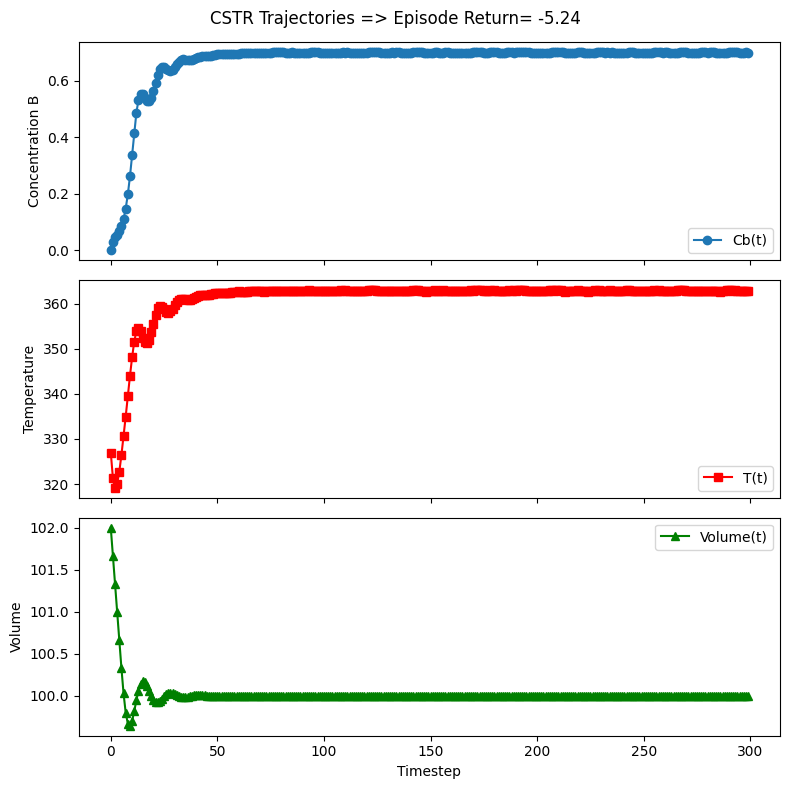

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 519  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 526          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0074371425 |
|    clip_fraction        | 0.0972       |
|    clip_range           | 0.2          |
|    entropy_loss         | -8.52        |
|    explained_variance   | 0.00542      |
|    learning_rate        | 0.0003       |
|    loss                 | 19.1         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00978     |
|    std                  | 1            |
|    value_loss           | 59.8         

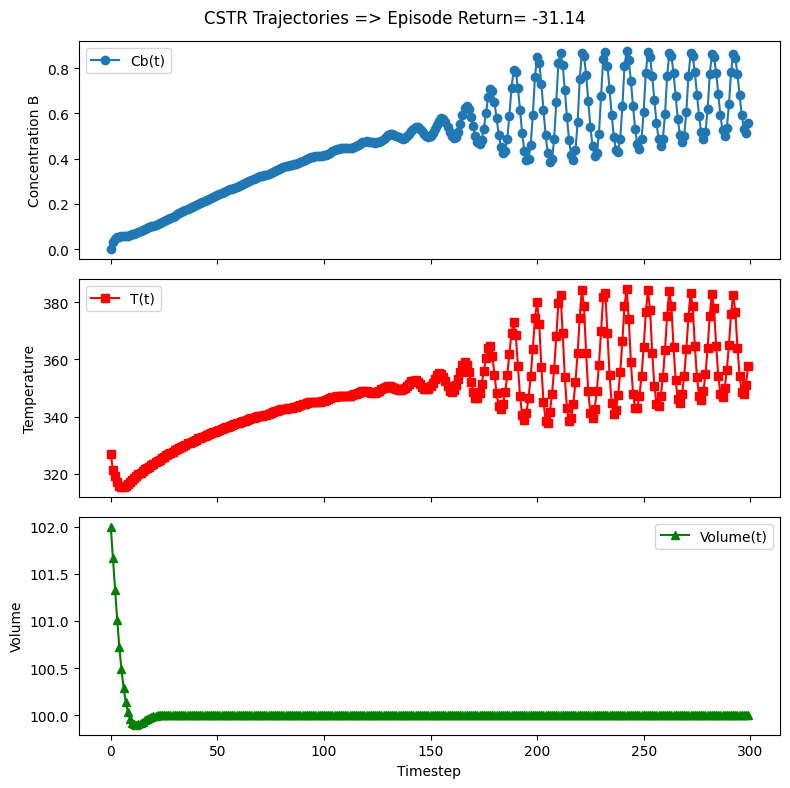


=== Transfer => dist_train= True ===
-----------------------------
| time/              |      |
|    fps             | 475  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 439         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008394873 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.32       |
|    explained_variance   | -0.000501   |
|    learning_rate        | 0.0003      |
|    loss                 | 9.96        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00925    |
|    std                  | 0.971       |
|    value_loss           | 23.4      

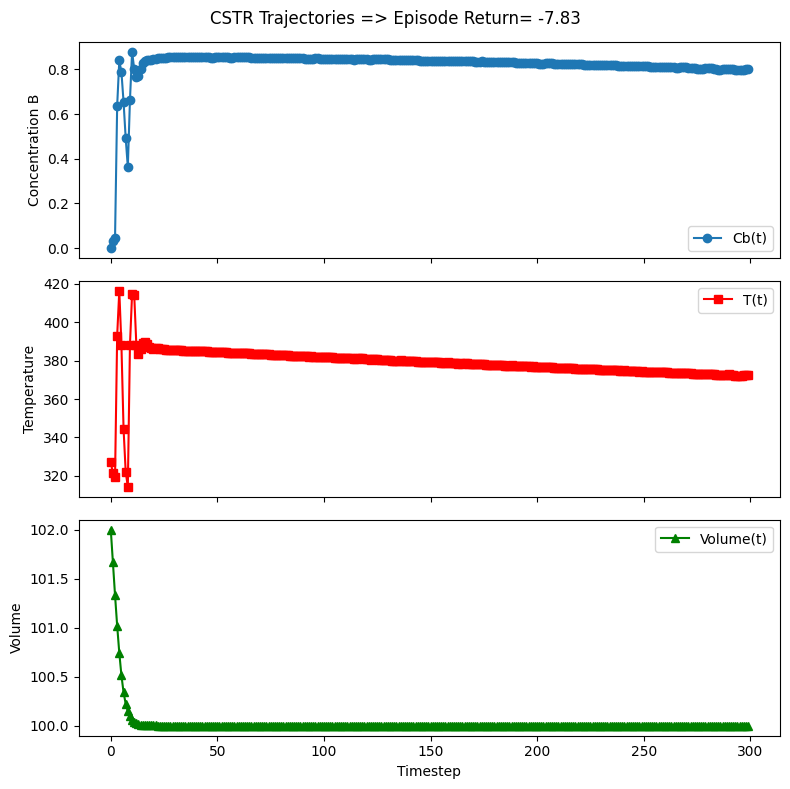

In [8]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import pyswarms as ps
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env

###########################################################################
# 1) cstr_CS1 and PID_velocity
###########################################################################
def PID_velocity(Ks, e, e_history, u_prev, ts, s_hist):
    """
    Dynamic velocity form PID for the two loops:
    Ks => array of shape(6,):
       [KpCb, tau_iCb, tau_dCb, KpV, tau_iV, tau_dV]
    e => 2D error: [ e_Cb, e_V ]
    e_history => past errors
    u_prev   => list of past control vectors
    ts => [t[i], t[i+1]]
    """
    dt= ts[1]- ts[0]

    # Gains for Cb-loop
    KpCb= Ks[0]
    tiCb= Ks[1]+ 1e-9
    tdCb= Ks[2]

    # Gains for V-loop
    KpV= Ks[3]
    tiV= Ks[4]+ 1e-9
    tdV= Ks[5]

    if len(e_history)<2:
        e_km1= e_history[-1]
        e_km2= e_history[-1]
    else:
        e_km1= e_history[-1]
        e_km2= e_history[-2]

    # e_k => [ e_Cb, e_V ]
    e_k= e

    # Past control => last
    last_u= u_prev[-1]  # shape(2,)

    # 1) The control for Tj => loop for e_Cb
    # velocity form => Δu_Cb = Kp [ eCb_k - eCb_{k-1} ] + ...
    dTc= (
        KpCb*( e_k[0]- e_km1[0] )
        + (KpCb/tiCb)* e_k[0]*dt
        - KpCb* tdCb*( e_k[0]- 2*e_km1[0] + e_km2[0] )/ dt
    )
    Tc= last_u[0]+ dTc
    Tc= np.clip(Tc, 290, 450)

    # 2) The control for Fin => loop for e_V
    dF= (
        KpV*( e_k[1]- e_km1[1] )
        + (KpV/tiV)* e_k[1]*dt
        - KpV* tdV*( e_k[1]- 2*e_km1[1] + e_km2[1] )/ dt
    )
    F= last_u[1]+ dF
    F= np.clip(F, 99,105)

    return np.array([Tc,F])

def cstr_CS1(x, t, u, Tf, Caf):
    """
    The CSTR ODE system from your snippet.
    x => [Ca, Cb, Cc, T, V]
    u => [Tc, Fin]
    """
    Tc= u[0]
    Fin= u[1]

    Ca= x[0]
    Cb= x[1]
    Cc= x[2]
    T=  x[3]
    V=  x[4]

    # process params
    Tf=350
    # ...
    # Reaction rates
    # (Same as your snippet)

    # for brevity, just do the same as your snippet
    rho= 1000
    Cp= 0.239
    UA= 5e4
    mdelH_AB= 5e3
    EoverR_AB= 8750
    k0_AB= 7.2e10
    rA= k0_AB* np.exp(-EoverR_AB/ T)* Ca

    mdelH_BC= 4e3
    EoverR_BC= 10750
    k0_BC= 8.2e10
    rB= k0_BC* np.exp(-EoverR_BC/ T)* Cb

    Fout= 100
    dCadt= (Fin* Caf- Fout* Ca)/V - rA
    dCbdt= rA - rB - Fout*Cb/ V
    dCcdt= rB - Fout*Cc/ V
    dTdt= (
        Fin/V*(Tf- T)
        + mdelH_AB/(rho*Cp)* rA
        + mdelH_BC/(rho* Cp)* rB
        + UA/(V* rho* Cp)*(Tc- T)
    )
    dVdt= Fin- Fout

    return [dCadt, dCbdt, dCcdt, dTdt, dVdt]


###########################################################################
# 2) The environment with 21D observation, 6D action
###########################################################################
class reactor_class(gym.Env):
    """
    Multi-step environment with full 21D obs from your snippet,
    and 6D action in [-1,1], mapped to real PID bounds from Table 2:

    Cb-loop:  Kp in [-5,25],  tau_i in [0,20], tau_d in [0,10]
    V-loop :  Kp in [0,1],    tau_i in [0,2],  tau_d in [0,1]
    """
    def __init__(self, ns=120, test=False, DS=False, normRL=False, dist=False,
                 dist_train=False, dist_obs=False, highop=False):
        super().__init__()
        self.ns= ns
        self.test= test
        self.DS= DS
        self.normRL= normRL
        self.dist= dist
        self.dist_train= dist_train
        self.dist_obs= dist_obs
        self.highop= highop

        # define action_space => 6D in [-1,1]
        self.action_space= spaces.Box(low=-1., high=1., shape=(6,), dtype=np.float32)

        # define observation_space => 21D from your snippet
        low_obs= np.full(21, -9999., dtype=np.float32)
        high_obs= np.full(21, 9999., dtype=np.float32)
        self.observation_space= spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        # define times
        self.t= np.linspace(0,100, ns)
        # define your setpoints
        # ...
        # We'll do a simpler approach for demonstration
        # or replicate your snippet's logic

        self.Ca_ss=0.80
        self.T_ss=327
        self.V_ss=102
        self.Caf=1.0
        self.u_history=[]
        self.e_history=[]
        self.s_history=[]

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.i= 0
        self.done= False

        # define initial state as your snippet
        # shape(21,). We'll store it in self.state
        # For demonstration, define the first 5 as [Ca, Cb, Cc, T, V],
        # the next 16 random or zero
        s= np.zeros(21, dtype=float)
        s[0]= self.Ca_ss  # Ca
        s[1]= 0.0         # Cb
        s[2]= 0.0         # Cc
        s[3]= self.T_ss   # T
        s[4]= self.V_ss   # V
        # rest are zero or as needed
        # e.g. s[15], s[16], ...
        # done
        self.state= s
        self.u_history=[]
        self.e_history=[]
        self.s_history=[]

        return s.astype(np.float32), {}

    def step(self, action):
        # step i
        # map action in [-1,1] => real gains
        gains= self._map_action_to_PID(action)

        # build error => [ e_Cb, e_V ]
        # In your snippet, e[0] = Ca_des - state[1], e[1] = V_des - state[4],
        # but let's do something simpler for demonstration
        # or replicate your snippet
        Ca_des= 0.7  # dummy
        V_des= 100
        e= np.array([ Ca_des- self.state[1], V_des- self.state[4] ])

        # if i<2 => default control
        if self.i<2:
            u= np.array([302, 99])
        else:
            # gather ts => [t[i-1], t[i]] for dt
            if len(self.e_history)<2:
                e_hist_arr= np.array([[0,0],[0,0]])
            else:
                e_hist_arr= np.array(self.e_history)
            if len(self.u_history)==0:
                u_prev= [ np.array([302,99]) ]
            else:
                u_prev= self.u_history

            ts= [ self.t[self.i-1], self.t[self.i] ]
            u= PID_velocity(gains, e, e_hist_arr, u_prev, ts, np.array(self.s_history))

        # clamp or not
        # integrate from state[0:5] => new cstr
        x_current= self.state[0:5].copy()
        y= odeint(cstr_CS1, x_current, self.t[self.i:self.i+2], args=(u, 350, 1.0))
        x_next= y[-1]

        # add noise
        x_next[0]+= np.random.uniform(-0.001, 0.001)
        x_next[3]+= np.random.uniform(-0.1, 0.1)

        # build new 21D state
        s_plus= self._build_new_state(x_next, u, e)
        self.state= s_plus

        # compute cost => snippet uses e[0]^2 + e[1]^2/10 + ...
        cost= (e[0]**2 + 0.1* e[1]**2)
        reward= float(-cost)

        # store
        self.e_history.append(e)
        self.u_history.append(u)
        self.s_history.append(self.state)

        self.i+=1
        done=False
        if self.i>= self.ns:
            done=True

        return self.state.astype(np.float32), reward, done, False, {}

    def _build_new_state(self, x_next, u, e):
        """
        Return new 21D array: your snippet references [0..4] => Ca, Cb, Cc, T, V
        Then more fields for previous states, setpoints, etc.
        We'll replicate your logic partially
        """
        s= np.zeros(21, dtype=float)
        s[0:5]= x_next  # [Ca, Cb, Cc, T, V]
        # we might store the last or older states in 5..14
        # store e.g. s[5..9] => old state, etc.
        # for demonstration, let's put them in
        if len(self.s_history)<1:
            old_state= np.zeros(21)
        else:
            old_state= self.s_history[-1]
        s[5:10]= old_state[0:5]

        # etc. We'll skip fully copying the snippet for brevity
        # store setpoints in s[15..20]
        # e.g. Ca_des=0.7, V_des=100
        s[15]= 0.7
        s[16]= 100
        # etc.
        return s

    def _map_action_to_PID(self, action_6):
        """
        Map the agent's 6D in [-1,1] => real gain bounds from table:

        Cb-loop: Kp in [-5,25], tau_i in [0,20], tau_d in [0,10]
        V-loop : Kp in [0,1],   tau_i in [0,2],  tau_d in [0,1]
        We do a simple linear scaling:
        """
        a= np.clip(action_6, -1,1)

        # cb-loop
        KpCb_low, KpCb_high= -5, 25
        tiCb_low, tiCb_high= 0, 20
        tdCb_low, tdCb_high= 0, 10

        # v-loop
        KpV_low, KpV_high= 0,1
        tiV_low, tiV_high= 0,2
        tdV_low, tdV_high= 0,1

        # a[0]->KpCb, a[1]->tiCb, a[2]-> tdCb
        # linear scale from [-1,1] => [low,high]
        KpCb= 0.5*(a[0]+1)*(KpCb_high- KpCb_low)+ KpCb_low
        tiCb= 0.5*(a[1]+1)*(tiCb_high- tiCb_low)+ tiCb_low
        tdCb= 0.5*(a[2]+1)*(tdCb_high- tdCb_low)+ tdCb_low

        # a[3]->KpV, a[4]->tiV, a[5]-> tdV
        KpV=  0.5*(a[3]+1)*(KpV_high- KpV_low)+ KpV_low
        tiV=  0.5*(a[4]+1)*(tiV_high- tiV_low)+ tiV_low
        tdV=  0.5*(a[5]+1)*(tdV_high- tdV_low)+ tdV_low

        return np.array([KpCb, tiCb, tdCb, KpV, tiV, tdV], dtype=float)


###########################################################################
# 3) Now define the PSO + PPO + Transfer with 21D obs, 6D action
###########################################################################
def make_cstr_env(ns=300, test=False, dist_train=False, highop=False):
    return reactor_class(ns=ns, test=test, dist_train=dist_train, highop=highop)

def check_cstr_env():
    env= make_cstr_env()
    # skip if your environment is partial, but let's do it
    check_env(env, warn=True)
    print("CSTR environment check => OK")

def pso_rollout_cost(params):
    """
    params => shape(n_particles, 6) in [-1,1].
    For each row => create env => run entire episode => sum reward => cost= -reward
    """
    n_particles= params.shape[0]
    costs= np.zeros(n_particles)
    for i in range(n_particles):
        gains= np.clip(params[i], -1,1)
        env= make_cstr_env()
        obs,_= env.reset()
        done=False
        total_r=0
        while not done:
            obs,r,done,_,_= env.step(gains)
            total_r+= r
        costs[i]= -total_r
    return costs

def run_pso():
    lower= np.array([-1]*6)
    upper= np.array([ 1]*6)
    bounds= (lower, upper)
    options= {'c1':0.5,'c2':0.3,'w':0.9}
    optimizer= ps.single.GlobalBestPSO(n_particles=20, dimensions=6,
                                       options=options, bounds=bounds)
    best_cost,best_pos= optimizer.optimize(pso_rollout_cost, iters=10)
    print("PSO => best cost:", best_cost)
    print("PSO => best param in [-1,1]:", best_pos)
    return best_cost,best_pos

def run_ppo_train(total_timesteps=20000, dist_train=False, highop=False):
    env= make_cstr_env(dist_train=dist_train, highop=highop)
    vec_env= DummyVecEnv([lambda: env])
    model= PPO("MlpPolicy", vec_env, verbose=1, n_steps=1024, batch_size=256)
    model.learn(total_timesteps= total_timesteps)
    return model

def evaluate_policy(model, dist_train=False, highop=False, episodes=3):
    rews=[]
    for _ in range(episodes):
        env= make_cstr_env(dist_train=dist_train, highop=highop)
        obs,_= env.reset()
        done=False
        ep_r=0
        while not done:
            act,_= model.predict(obs, deterministic=True)
            obs,r,done,_,_= env.step(act)
            ep_r+= r
        rews.append(ep_r)
    return np.mean(rews)

def run_and_plot(policy=None, pid_gains=None, dist_train=False, highop=False):
    """
    We'll store just e.g. Cb[t], T[t], V[t].
    The environment stores them in self.state for each step?
    In your snippet, you store them in self.state or self.[Ca, T].
    We'll adapt by reading from env.s_history if needed.
    """
    env= make_cstr_env(dist_train=dist_train, highop=highop)
    obs,_= env.reset()
    done=False
    ep_r=0
    c_history=[]
    t_history=[]
    v_history=[]
    step_idx=0
    while not done:
        # read from env.state => let's say s[1]= Cb, s[3]= T, s[4]= V
        s= env.state
        c_history.append(s[1])  # Cb
        t_history.append(s[3])  # T
        v_history.append(s[4])  # V

        if policy is not None:
            act,_= policy.predict(obs, deterministic=True)
        else:
            act= pid_gains
        obs,r,done,_,_= env.step(act)
        ep_r+= r
        step_idx+=1

    # plot
    ts= np.arange(step_idx)
    fig, ax= plt.subplots(3,1, figsize=(8,8), sharex=True)
    ax[0].plot(ts, c_history, '-o', label="Cb(t)")
    ax[0].set_ylabel("Concentration B")
    ax[0].legend()

    ax[1].plot(ts, t_history, '-s', c='r', label="T(t)")
    ax[1].set_ylabel("Temperature")
    ax[1].legend()

    ax[2].plot(ts, v_history, '-^', c='g', label="Volume(t)")
    ax[2].set_ylabel("Volume")
    ax[2].set_xlabel("Timestep")
    ax[2].legend()

    plt.suptitle(f"CSTR Trajectories => Episode Return= {ep_r:.2f}")
    plt.tight_layout()
    plt.show()


def main_demo():
    check_cstr_env()

    # A) PSO
    best_cost, best_pos= run_pso()
    print("PSO done => Evaluate & Plot with best param")
    run_and_plot(pid_gains= best_pos)

    # B) PPO local
    model= run_ppo_train(total_timesteps=20000)
    final_r= evaluate_policy(model)
    print(f"PPO final average reward => {final_r:.3f}")
    run_and_plot(policy=model)

    # C) Simple transfer => e.g. dist_train=True
    print("\n=== Transfer => dist_train= True ===")
    from stable_baselines3.common.vec_env import DummyVecEnv
    env2= make_cstr_env(dist_train=True)
    vec_env2= DummyVecEnv([lambda: env2])
    model.set_env(vec_env2)
    model.learn(total_timesteps=10000)
    final_r2= evaluate_policy(model, dist_train=True)
    print(f"After transfer PPO => reward= {final_r2:.3f}")
    run_and_plot(policy=model, dist_train=True)

if __name__=="__main__":
    main_demo()
